<a href="https://colab.research.google.com/github/alexandrumoldovan1/job-change-ml-classification/blob/main/notebooks/02_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf job-change-ml-classification
!git clone https://github.com/alexandrumoldovan1/job-change-ml-classification.git
%cd job-change-ml-classification


Cloning into 'job-change-ml-classification'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 287.77 KiB | 4.72 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/job-change-ml-classification


In [ ]:
train = pd.read_csv("data/job_change_train.csv")
test  = pd.read_csv("data/job_change_test.csv")

In [ ]:
import pandas as pd

TRAIN_PATH = "data/job_change_train.csv"
TEST_PATH  = "data/job_change_test.csv"

TARGET = "willing_to_change_job"
ID_COL = "id"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

# Separate features and target
X = train.drop(columns=[TARGET])

# MAP target to numeric
y = train[TARGET].map({"No": 0, "Yes": 1}).astype(int)

# Remove ID from features
if ID_COL in X.columns:
    X = X.drop(columns=[ID_COL])

# Test features
X_test = test.copy()
if ID_COL in X_test.columns:
    X_test_features = X_test.drop(columns=[ID_COL])
else:
    X_test_features = X_test
print(y.value_counts())


Train shape: (12427, 15)
Test shape : (3308, 14)
willing_to_change_job
0    9340
1    3087
Name: count, dtype: int64


In [ ]:
# Detect categorical and numerical columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns:")
print(cat_cols)

print("\nNumerical columns:")
print(num_cols)


Categorical columns:
['gender', 'education', 'field_of_studies', 'is_studying', 'county', 'years_since_job_change', 'years_of_experience', 'size_of_company', 'type_of_company']

Numerical columns:
['age', 'relative_wage', 'hours_of_training', 'is_certified']


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


In [ ]:
from sklearn.model_selection import StratifiedKFold

RANDOM_STATE = 42
SCORING = "balanced_accuracy"

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

models_and_grids = [

    ("LogReg_L2",
     LogisticRegression(penalty="l2", solver="liblinear", max_iter=5000),
     {
         "clf__C": [0.1, 1, 10],
         "clf__class_weight": [None, "balanced"]
     }),

    ("LogReg_L1",
     LogisticRegression(penalty="l1", solver="liblinear", max_iter=5000),
     {
         "clf__C": [0.05, 0.1, 1, 10],
         "clf__class_weight": [None, "balanced"]
     }),

    ("KNN",
     KNeighborsClassifier(),
     {
         "clf__n_neighbors": [5, 15, 31],
         "clf__weights": ["uniform", "distance"],
         "clf__p": [1, 2]
     }),

    ("SVM_RBF",
     SVC(kernel="rbf"),
     {
         "clf__C": [0.5, 1, 5],
         "clf__gamma": ["scale", 0.01, 0.1],
         "clf__class_weight": [None, "balanced"]
     }),

    ("DecisionTree",
     DecisionTreeClassifier(random_state=RANDOM_STATE),
     {
         "clf__max_depth": [3, 5, 10, None],
         "clf__min_samples_leaf": [1, 5, 20],
         "clf__class_weight": [None, "balanced"]
     }),

    ("RandomForest",
     RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
     {
         "clf__n_estimators": [300, 600],
         "clf__max_depth": [None, 12],
         "clf__min_samples_leaf": [1, 5, 15],
         "clf__class_weight": [None, "balanced_subsample"]
     }),

    ("GBM",
     HistGradientBoostingClassifier(random_state=RANDOM_STATE),
     {
         "clf__learning_rate": [0.03, 0.1],
         "clf__max_depth": [3, 6, None],
         "clf__max_leaf_nodes": [31, 63]
     }),

    ("XGBoost",
     XGBClassifier(
         random_state=RANDOM_STATE,
         n_jobs=-1,
         tree_method="hist",
         eval_metric="logloss",
         use_label_encoder=False
     ),
     {
         "clf__n_estimators": [300, 600],
         "clf__max_depth": [3, 5],
         "clf__learning_rate": [0.03, 0.1],
         "clf__subsample": [0.8, 1.0],
         "clf__colsample_bytree": [0.8, 1.0],
         "clf__scale_pos_weight": [1, 2, 4]
     })
]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import os

os.makedirs("outputs", exist_ok=True)

results = []
best_estimators = {}

for name, clf, grid in models_and_grids:
    print("\n==============================")
    print(f"Running model: {name}")
    print("==============================")


    if name == "GBM":

        preprocess_local = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
                ]), cat_cols)
            ]
        )
        n_jobs_gs = 1

    elif name == "RandomForest":

        preprocess_local = preprocess
        n_jobs_gs = 1

    else:

        preprocess_local = preprocess
        n_jobs_gs = -1

    pipe = Pipeline(steps=[
        ("prep", preprocess_local),
        ("clf", clf)
    ])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="balanced_accuracy",
        cv=cv,
        n_jobs=n_jobs_gs,
        verbose=1
    )

    try:
        gs.fit(X, y)

        results.append({
            "model": name,
            "best_cv_balanced_accuracy": gs.best_score_,
            "best_params": gs.best_params_
        })

        best_estimators[name] = gs.best_estimator_

        print(f"✅ SUCCESS: {name}")
        print(f"   Best CV balanced accuracy = {gs.best_score_:.4f}")

    except Exception as e:
        print(f"❌ FAILED: {name}")
        print("   Error:", repr(e))


# Final comparative table

results_df = (
    pd.DataFrame(results)
    .sort_values("best_cv_balanced_accuracy", ascending=False)
    .reset_index(drop=True)
)

display(results_df)
results_df.to_csv("outputs/cv_results.csv", index=False)

print("\nFINAL BEST MODEL:")
print(results_df.iloc[0])



Running model: LogReg_L2
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ SUCCESS: LogReg_L2
   Best CV balanced accuracy = 0.7651

Running model: LogReg_L1
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ SUCCESS: LogReg_L1
   Best CV balanced accuracy = 0.7631

Running model: KNN
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ SUCCESS: KNN
   Best CV balanced accuracy = 0.6875

Running model: SVM_RBF
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ SUCCESS: SVM_RBF
   Best CV balanced accuracy = 0.7694

Running model: DecisionTree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ SUCCESS: DecisionTree
   Best CV balanced accuracy = 0.7526

Running model: RandomForest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ SUCCESS: RandomForest
   Best CV balanced accuracy = 0.7699

Running model: GBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ SUCCESS: GBM
   Best CV balanced accuracy = 0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:55:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ SUCCESS: XGBoost
   Best CV balanced accuracy = 0.7685


,model,best_cv_balanced_accuracy,best_params
0,RandomForest,0.769878,"{'clf__class_weight': 'balanced_subsample', 'c..."
1,SVM_RBF,0.769447,"{'clf__C': 1, 'clf__class_weight': 'balanced',..."
2,XGBoost,0.768521,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."
3,LogReg_L2,0.765076,"{'clf__C': 0.1, 'clf__class_weight': 'balanced'}"
4,LogReg_L1,0.763093,"{'clf__C': 0.1, 'clf__class_weight': 'balanced'}"
5,DecisionTree,0.752619,"{'clf__class_weight': 'balanced', 'clf__max_de..."
6,GBM,0.726786,"{'clf__learning_rate': 0.03, 'clf__max_depth':..."
7,KNN,0.687493,"{'clf__n_neighbors': 31, 'clf__p': 1, 'clf__we..."



FINAL BEST MODEL:
model                                                             RandomForest
best_cv_balanced_accuracy                                             0.769878
best_params                  {'clf__class_weight': 'balanced_subsample', 'c...
Name: 0, dtype: object


In [ ]:
# =============================
# POINT 7: Final model selection
# =============================

best_model_name = results_df.loc[0, "model"]
best_score = results_df.loc[0, "best_cv_balanced_accuracy"]

print("FINAL BEST MODEL:", best_model_name)
print("Expected balanced accuracy on test (CV mean):", best_score)

print("\nTop 3 models:")
display(results_df.head(3))


FINAL BEST MODEL: RandomForest
Expected balanced accuracy on test (CV mean): 0.7698776714101859

Top 3 models:


,model,best_cv_balanced_accuracy,best_params
0,RandomForest,0.769878,"{'clf__class_weight': 'balanced_subsample', 'c..."
1,SVM_RBF,0.769447,"{'clf__C': 1, 'clf__class_weight': 'balanced',..."
2,XGBoost,0.768521,"{'clf__colsample_bytree': 0.8, 'clf__learning_..."


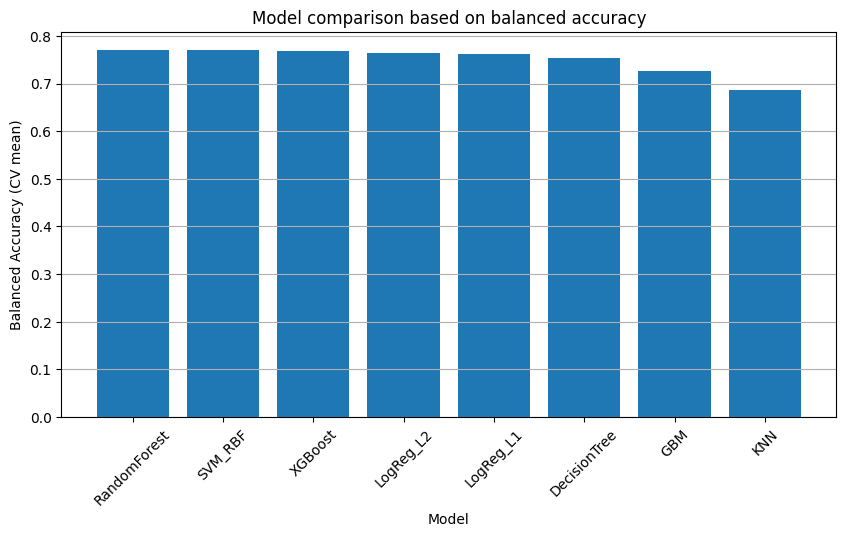

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(
    results_df["model"],
    results_df["best_cv_balanced_accuracy"]
)

plt.ylabel("Balanced Accuracy (CV mean)")
plt.xlabel("Model")
plt.title("Model comparison based on balanced accuracy")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.show()
